<a href="https://colab.research.google.com/github/ReJackTion/cat304/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the dataset

In [1]:
!pip install -q kaggle

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore') #ignore warning to imporve readability

To upload Kaggle's API to download dataset from Kaggle

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rejacktion","key":"65206b6c0a80785cc0e9a39aa2b96461"}'}

In [5]:
!mkdir ~/.kaggle #make a new folder
!cp /content/kaggle.json ~/.kaggle/ #copy file to that folder
!chmod 600 ~/.kaggle/kaggle.json #to allow read and write the file

dataset source:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:42<00:00, 121MB/s]
100% 2.29G/2.29G [00:42<00:00, 58.1MB/s]


In [7]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# Creating Data Generators

In [8]:
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

In [9]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 32

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [11]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Model Building

## Model 1 (MobileNetV2)

In [12]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

mobilenet.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 fc1 (Dense)                 (None, 64)                81984     
                                                                 
 fc2 (Dense)                 (None, 32)                2080      
                                                                 
 fc3 (Dense)                 (None, 16)                528       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 2,342,593
Trainable params: 84,609
Non-trainable params: 2,257,984
_________________________________________

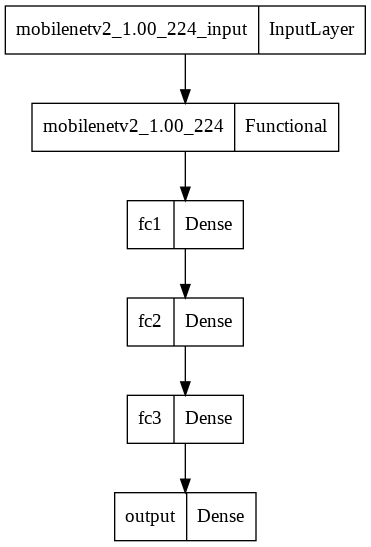

In [13]:
model_1 = tf.keras.models.Sequential([
  mobilenet,

  tf.keras.layers.Dense(64, activation='leaky_relu', kernel_regularizer='l2', name='fc1'),
  tf.keras.layers.Dense(32, activation='leaky_relu', kernel_regularizer='l2', name='fc2'),
  tf.keras.layers.Dense(16, activation='leaky_relu', kernel_regularizer='l2', name='fc3'),

  tf.keras.layers.Dense(1, activation='sigmoid', name='output')
  ])


print(model_1.summary())
tf.keras.utils.plot_model(model_1)

In [15]:
EPOCHS = 10

model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history_1 = model_1.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
163/163 [==============================] - 129s 770ms/step - loss: 1.0477 - accuracy: 0.9227 - auc: 0.9727 - val_loss: 0.6392 - val_accuracy: 0.9375 - val_auc: 0.9844
Epoch 2/10
163/163 [==============================] - 122s 745ms/step - loss: 0.4816 - accuracy: 0.9477 - auc: 0.9863 - val_loss: 0.6502 - val_accuracy: 0.8125 - val_auc: 0.9375
Epoch 3/10
163/163 [==============================] - 121s 742ms/step - loss: 0.3325 - accuracy: 0.9536 - auc: 0.9886 - val_loss: 0.9734 - val_accuracy: 0.6250 - val_auc: 0.9219
Epoch 4/10
163/163 [==============================] - 121s 743ms/step - loss: 0.2801 - accuracy: 0.9519 - auc: 0.9871 - val_loss: 0.5849 - val_accuracy: 0.7500 - val_auc: 1.0000
Epoch 5/10
163/163 [==============================] - 125s 767ms/step - loss: 0.2293 - accuracy: 0.9578 - auc: 0.9909 - val_loss: 0.3756 - val_accuracy: 0.9375 - val_auc: 0.9844
Epoch 6/10
163/163 [==============================] - 126s 775ms/step - loss: 0.2155 - accuracy: 0.9582 - auc:

In [22]:
def evaluate(model):  
  results = model.evaluate(test_data, verbose=0)

  accuracy = results[1]
  auc = results[2]

  true_labels = test_data.labels
  pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int))
  cm = confusion_matrix(true_labels, pred_labels)

  tn, fp, fn, tp = cm.ravel()

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  print("Accuracy: {:.2f}".format(accuracy))
  print("AUC: {:.2f}".format(auc))
  print("Precision: {:.2f}".format(precision))
  print("Recall: {:.2f}".format(recall))

In [23]:
evaluate(model_1)

Accuracy: 0.86
AUC: 0.94
Precision: 0.62
Recall: 0.71


## Model 2 (ResNet50V2)

In [52]:
resnet = tf.keras.applications.resnet_v2.ResNet50V2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

resnet.trainable = False

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 fc1 (Dense)                 (None, 64)                131136    
                                                                 
 fc2 (Dense)                 (None, 32)                2080      
                                                                 
 fc3 (Dense)                 (None, 16)                528       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 23,698,561
Trainable params: 133,761
Non-trainable params: 23,564,800
_________________________________________________________________
None


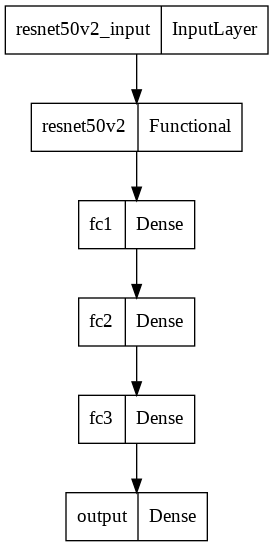

In [36]:
model_2 = tf.keras.models.Sequential([
  resnet,

  tf.keras.layers.Dense(64, activation='leaky_relu', kernel_regularizer='l2', name='fc1'),
  tf.keras.layers.Dense(32, activation='leaky_relu', kernel_regularizer='l2', name='fc2'),
  tf.keras.layers.Dense(16, activation='leaky_relu', kernel_regularizer='l2', name='fc3'),

  tf.keras.layers.Dense(1, activation='sigmoid', name='output')
  ])


print(model_2.summary())
tf.keras.utils.plot_model(model_2)

In [37]:
EPOCHS = 10

model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history_2 = model_2.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
163/163 [==============================] - 181s 820ms/step - loss: 0.9415 - accuracy: 0.9317 - auc: 0.9772 - val_loss: 1.0034 - val_accuracy: 0.7500 - val_auc: 0.9844
Epoch 2/10
163/163 [==============================] - 133s 813ms/step - loss: 0.4437 - accuracy: 0.9434 - auc: 0.9822 - val_loss: 0.9529 - val_accuracy: 0.7500 - val_auc: 0.9453
Epoch 3/10
163/163 [==============================] - 132s 811ms/step - loss: 0.2977 - accuracy: 0.9601 - auc: 0.9886 - val_loss: 0.7499 - val_accuracy: 0.7500 - val_auc: 0.9531
Epoch 4/10
163/163 [==============================] - 133s 817ms/step - loss: 0.2532 - accuracy: 0.9546 - auc: 0.9880 - val_loss: 0.4708 - val_accuracy: 0.8750 - val_auc: 1.0000
Epoch 5/10
163/163 [==============================] - 133s 814ms/step - loss: 0.2149 - accuracy: 0.9584 - auc: 0.9896 - val_loss: 0.5044 - val_accuracy: 0.7500 - val_auc: 0.9219
Epoch 6/10
163/163 [==============================] - 132s 808ms/step - loss: 0.1977 - accuracy: 0.9590 - auc:

In [38]:
evaluate(model_2)

Accuracy: 0.88
AUC: 0.95
Precision: 0.63
Recall: 0.72


## Model 3

In [53]:
# Unfreeze all of the layers in the base model
resnet.trainable = True

# Refreeze every layer except for the last 3
for layer in resnet.layers[:-37]:
  layer.trainable = False

In [54]:
for layer_number, layer in enumerate(resnet.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 fc2 (Dense)                 (None, 64)                131136    
                                                                 
 fc3 (Dense)                 (None, 32)                2080      
                                                                 
 fc4 (Dense)                 (None, 16)                528       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 23,698,561
Trainable params: 15,104,641
Non-trainable params: 8,593,920
_________________________________________________________________
None


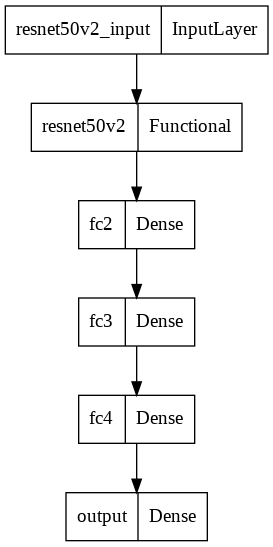

In [55]:
model_3 = tf.keras.models.Sequential([
  resnet,

  tf.keras.layers.Dense(64, activation='leaky_relu', kernel_regularizer='l2', name='fc2'),
  tf.keras.layers.Dense(32, activation='leaky_relu', kernel_regularizer='l2', name='fc3'),
  tf.keras.layers.Dense(16, activation='leaky_relu', kernel_regularizer='l2', name='fc4'),

  tf.keras.layers.Dense(1, activation='sigmoid', name='output')
  ])


print(model_3.summary())
tf.keras.utils.plot_model(model_3)

In [56]:
EPOCHS = 10

model_3.compile(
    optimizer = tf.keras.optimizers.Adam(5e-4), # 2x lower learning rate than default,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history_3 = model_3.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
163/163 [==============================] - 144s 850ms/step - loss: 1.0704 - accuracy: 0.9551 - auc: 0.9861 - val_loss: 3.8306 - val_accuracy: 0.6250 - val_auc: 0.6875
Epoch 2/10
163/163 [==============================] - 138s 847ms/step - loss: 0.3732 - accuracy: 0.9714 - auc: 0.9943 - val_loss: 0.5758 - val_accuracy: 0.8125 - val_auc: 1.0000
Epoch 3/10
163/163 [==============================] - 138s 843ms/step - loss: 0.1941 - accuracy: 0.9822 - auc: 0.9980 - val_loss: 0.2591 - val_accuracy: 0.8750 - val_auc: 0.9844
Epoch 4/10
163/163 [==============================] - 137s 839ms/step - loss: 0.1288 - accuracy: 0.9841 - auc: 0.9982 - val_loss: 0.3659 - val_accuracy: 0.8750 - val_auc: 1.0000
Epoch 5/10
163/163 [==============================] - 136s 837ms/step - loss: 0.1011 - accuracy: 0.9839 - auc: 0.9979 - val_loss: 0.3914 - val_accuracy: 0.8750 - val_auc: 0.9844
Epoch 6/10
163/163 [==============================] - 137s 838ms/step - loss: 0.0805 - accuracy: 0.9860 - auc:

In [57]:
evaluate(model_3)

Accuracy: 0.89
AUC: 0.97
Precision: 0.63
Recall: 0.74


# Model Selection

In [59]:
print("Model 1:--")
evaluate(model_1)
print("\nModel 2:--")
evaluate(model_2)
print("\nModel 3:--")
evaluate(model_3)

Model 1:--
Accuracy: 0.85
AUC: 0.95
Precision: 0.64
Recall: 0.75

Model 2:--
Accuracy: 0.89
AUC: 0.96
Precision: 0.61
Recall: 0.67

Model 3:--
Accuracy: 0.89
AUC: 0.97
Precision: 0.64
Recall: 0.74



As we can see, model 3 performs the best. Therefore, model 3 is chosen.

In [58]:
model_3.save_weights('pneumonia_prediction_model', save_format='h5')